## Prerequisites

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler


import originalcsv file

In [3]:
df = pd.read_csv('mental-heath-in-tech-2016_20161114.csv', encoding='utf-8')

First we print a preview of our dataframe to get a broad overview of the data

In [4]:
print(df.head())


   Are you self-employed?  \
0                       0   
1                       0   
2                       0   
3                       1   
4                       0   

  How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                                NaN           
4                                               6-25           

   Is your employer primarily a tech company/organization?  \
0                                                1.0         
1                                                1.0         
2                                                1.0         
3                                                NaN         
4                                                0.0         

   Is your primary role within your company related to tech/IT?  \


# 2.1 Dataset Overview

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0   Are you self-employed?                                                                                                                                                            1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

#### Dataset Overview Analysis

The dataset consists of 1433 responses from a mental health survey in tech companies 
with 63 columns (variables) covering different aspects:

Data Structure:
- Number of observations: 1433 entries
- Number of variables: 63 columns

Data Types:
1. Numerical Variables (7 columns):
   - Integer (int64): 4 columns
     Examples: age, self-employment status, treatment history
   - Float (float64): 3 columns
     Examples: tech company indicator, tech role indicator
   
2. Categorical Variables (56 columns):
   - Object type variables covering:
     - Employee benefits and resources
     - Workplace attitudes towards mental health
     - Personal mental health history
     - Demographics
     - Employment characteristics

Missing Values:
Some key variables show missing data patterns:
- Complete responses (1433 non-null) for demographic variables like age and gender
- Partial responses (1146 non-null) for current employer-related questions
- Limited responses (263-287 non-null) for specific mental health treatment questions

The high dimensionality and mix of data types suggests the need for:
1. Careful handling of missing values
2. Appropriate encoding of categorical variables
3. Dimensionality reduction for meaningful analysis


I want to start to explore the data. Therfore some standard visualizations should help to get an overview of distributions and correlations.

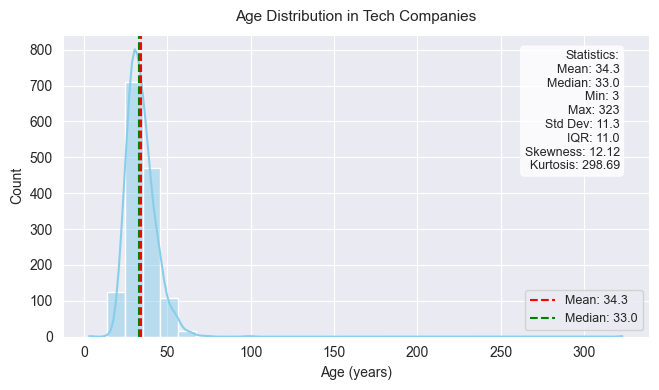

In [9]:
# Rename age column for easier handling
df = df.rename(columns={'What is your age?': 'age'})

# Calculate age statistics
age_mean = df['age'].mean()
age_median = df['age'].median()
age_std = df['age'].std()
age_skew = df['age'].skew()
age_kurtosis = df['age'].kurtosis()
age_iqr = df['age'].quantile(0.75) - df['age'].quantile(0.25)
age_min = df['age'].min()
age_max = df['age'].max()

# Create figure with exact A4 width (minus margins)
plt.figure(figsize=(6.69, 4))  # Width matches A4 margins, height adjusted for proportion

# Set font to match document
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Create the main distribution plot
sns.histplot(data=df, x='age', bins=30, kde=True, color='skyblue')

# Add a vertical line for mean and median
plt.axvline(age_mean, color='red', linestyle='--', label=f'Mean: {age_mean:.1f}')
plt.axvline(age_median, color='green', linestyle='--', label=f'Median: {age_median:.1f}')

# Customize the plot
plt.title('Age Distribution in Tech Companies', fontsize=11, pad=10)
plt.xlabel('Age (years)', fontsize=10)
plt.ylabel('Count', fontsize=10)

# Add statistical annotations in a text box
stats_text = (f'Statistics:\n'
            f'Mean: {age_mean:.1f}\n'
            f'Median: {age_median:.1f}\n'
            f'Min: {age_min}\n'
            f'Max: {age_max}\n'
            f'Std Dev: {age_std:.1f}\n'
            f'IQR: {age_iqr:.1f}\n'
            f'Skewness: {age_skew:.2f}\n'
            f'Kurtosis: {age_kurtosis:.2f}')

# Place text box in upper right corner
plt.text(0.95, 0.95, stats_text,
        transform=plt.gca().transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=9)  # Slightly smaller font for stats

# Add legend with smaller font
plt.legend(fontsize=9)

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Save with exact dimensions and high DPI for clarity
plt.savefig('age_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

The age distribution of survey respondents shows:
- Mean age of 34.3 years with median of 33.0 years, indicating a slightly right-skewed distribution
- Range from 3 to 323 years reveals clear data quality issues that need to be addressed:
 * The minimum age of 3 years is invalid for a workforce survey
 * The maximum age of 323 years is impossible and likely a data entry error
- Standard deviation of 11.3 years shows moderate spread when excluding outliers
- IQR (Interquartile Range) of 11.0 years represents the range between the 25th and 75th percentiles,
 indicating that the middle 50% of employees are within an 11-year age span
- Strong positive skewness (12.12) indicates a long right tail, partially due to invalid outliers
- Very high kurtosis (298.69) reflects the extreme outliers in the data

Data Quality Implications:
1. Data cleaning is required to handle invalid age entries
2. Age validation rules should be implemented for future surveys
3. Analysis should potentially focus on the core age range excluding outliers
4. Statistics like median and IQR are more reliable than mean/std given the outliers

Despite data quality issues, the visualization shows that the majority of the workforce 
is concentrated in the early-to-mid 30s range, which should be the primary focus for 
mental health support program design.

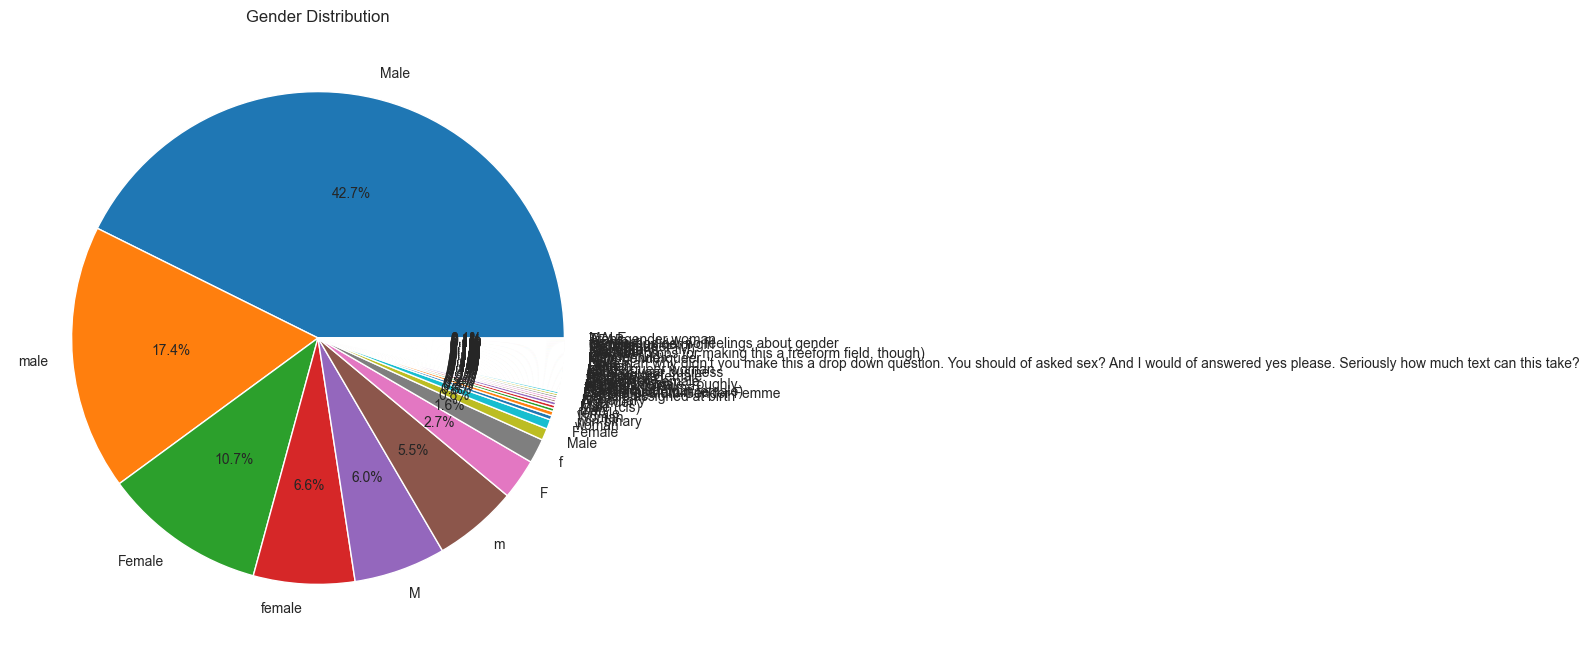

In [838]:
# Gender breakdown
gender_counts = df['What is your gender?'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

There are a lot of categories that mean the same, but in different variations. This should also be addressed in the data cleaning.

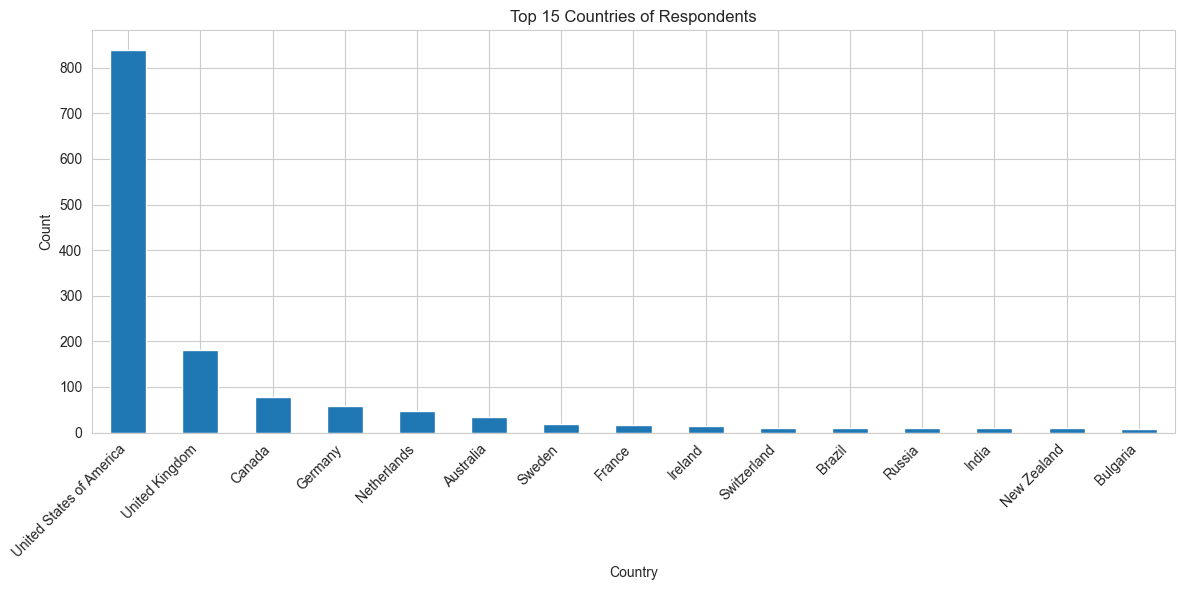

In [839]:
# Geographic distribution
country_counts = df['What country do you live in?'].value_counts().head(15)
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar')
plt.title('Top 15 Countries of Respondents')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The graph clearly shows that the USA has by far the largest number of respondents, providing a much more robust and statistically significant sample size compared to other countries.


Reasons to truncate the data for USA:
- Data Homogeneity: It can be beneficial that focus lies on respondents from USA for different reasons: Focusing on a single country eliminates potential confounding variables related to different cultural, legal, and healthcare systems across countries, allowing for more controlled and meaningful comparisons within the dataset.
- Relevance to Tech Industry: The USA is home to major tech hubs like Silicon Valley, Seattle, and New York, making the data particularly relevant to understanding mental health issues in the global tech industry's epicenter.
- Statistical Power: With such a large sample from the USA, you're more likely to detect subtle patterns or effects that might not be visible in smaller subsets from other countries.
- Reduced Noise: Including data from countries with very few respondents could introduce noise and potentially skew results due to small, non-representative samples from those locations.

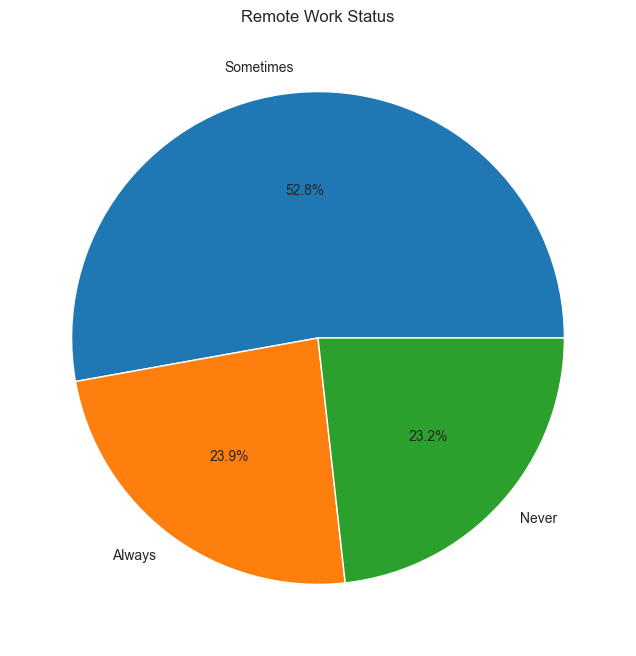

In [840]:
# Remote work status
remote_counts = df['Do you work remotely?'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(remote_counts.values, labels=remote_counts.index, autopct='%1.1f%%')
plt.title('Remote Work Status')
plt.show()

## Observations

1. **Distribution of Remote Work:**
   - 52.8% of respondents work remotely sometimes
   - 23.9% work remotely always
   - 23.2% never work remotely

2. **Prevalence of Remote Work:**
   - 76.7% of respondents have some form of remote work arrangement (sometimes or always)

3. **Balance:**
   - There's an almost equal split between those who always work remotely and those who never do

## Insights

1. **Flexible Work Culture:**
   - The majority of tech workers have access to some form of remote work, indicating a flexible work culture in the industry

2. **Hybrid Model Dominance:**
   - The largest segment working remotely "sometimes" suggests a hybrid work model is most common

## Implications

1. **Mental Health Considerations:**
   - Different remote work statuses may have varying impacts on mental health, requiring tailored support strategies

2. **Company Policies:**
   - Organizations need to develop (mental health) policies that accommodate the diverse remote work arrangements

3. **Technology Infrastructure:**
   - Companies must ensure robust technology infrastructure to support the high prevalence of remote and hybrid work

6. **Performance Management:**
   - New approaches to performance evaluation may be needed to fairly assess employees across different work arrangements

7. **Office Space Utilization:**
   - With most employees working remotely at least sometimes, companies might reconsider their office space needs and designs

8. **Training and Development:**
   - Organizations should adapt their training and development programs to be effective across all remote work statuses

This analysis suggests that the tech industry has widely embraced remote work, with implications spanning from mental health support to operational strategies. Companies need to adapt their policies and practices to effectively manage and support employees across various remote work arrangements, considering the potential impacts on mental health, productivity, and overall employee well-being.

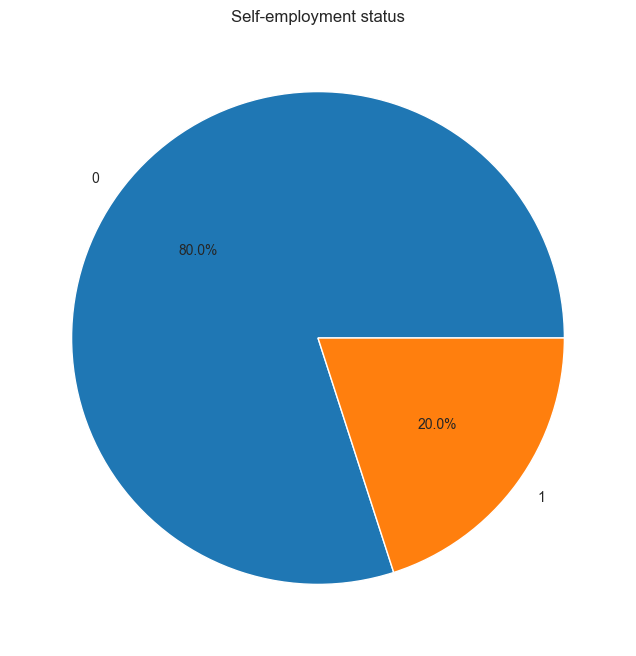

In [841]:
# Self-employment status
selfemp_counts = df['Are you self-employed?'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(selfemp_counts.values, labels=selfemp_counts.index, autopct='%1.1f%%')
plt.title('Self-employment status')
plt.show()

## Observations

1. **Employment Distribution**:
   - 80% of respondents are employees
   - 20% of respondents are self-employed

2. **Dominant Workforce Type**:
   - The vast majority of respondents work in traditional employment settings

3. **Significant Self-Employed Minority**:
   - One-fifth of respondents are self-employed, representing a notable portion of the tech workforce

## Insights

1. **Differing Work Environments**:
   - Self-employed individuals likely work in varied settings (home, co-working spaces) compared to company employees
   - Work environment diversity may impact mental health differently

2. **Policy and Initiative Exposure**:
   - 80% of respondents are subject to company-wide mental health policies and initiatives
   - Self-employed individuals lack exposure to structured corporate mental health support

3. **Varied Support Systems**:
   - Company employees likely have access to employer-provided health insurance and Employee Assistance Programs
   - Self-employed individuals typically lack these structured support systems

4. **Performance Evaluation Differences**:
   - Company employees face stress from formal performance reviews and KPIs
   - Self-employed individuals may experience different types of work-related stress

5. **Workplace Dynamics**:
   - Analysis of mental health in company settings involves factors like team dynamics and workplace culture
   - These factors are less relevant or differently structured for self-employed individuals

## Implications

1. **Data Analysis Strategy**:
   - Focusing analysis on the 80% company employees would yield more relevant insights for corporate environments
   - Including self-employed workers could skew results for company-wide mental health strategies

2. **Targeted Interventions**:
   - Mental health initiatives in tech companies should be designed with the 80% employee majority in mind
   - Separate strategies may be needed to address mental health for the self-employed tech workforce

5. **Policy Development**:
   - Company policies should be developed with the understanding that they will impact the majority (80%) of the tech workforce
   - Policymakers should consider how to extend mental health support to the self-employed tech sector

This analysis suggests that while focusing on company employees for mental health initiatives in tech is pragmatic, the industry should also consider broader strategies to support the mental health of its diverse workforce, including the significant self-employed segment.

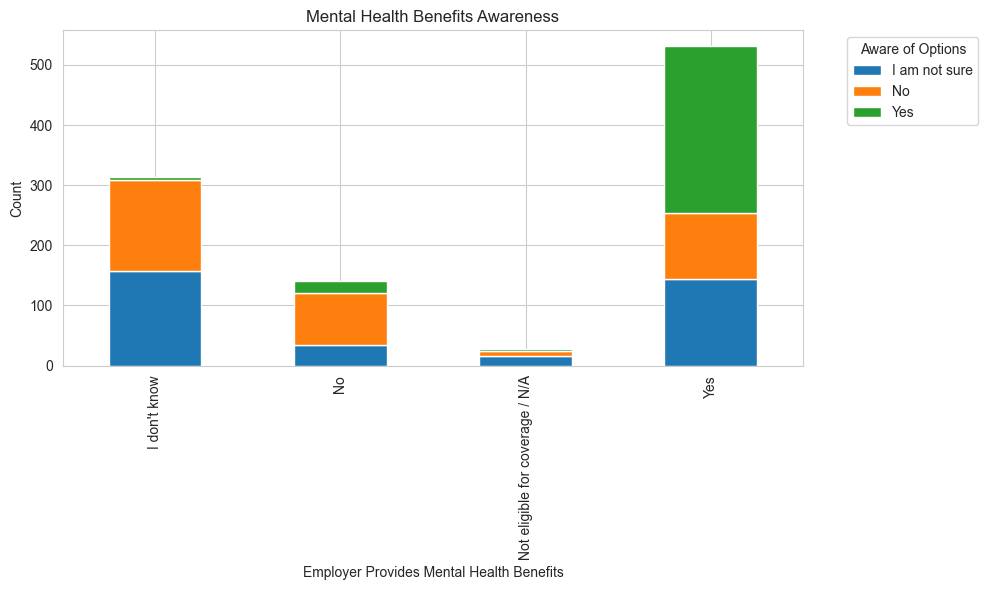

In [842]:
# Mental health benefits awareness
benefits_aware = pd.crosstab(df['Does your employer provide mental health benefits as part of healthcare coverage?'], 
                             df['Do you know the options for mental health care available under your employer-provided coverage?'])
benefits_aware.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Mental Health Benefits Awareness')
plt.xlabel('Employer Provides Mental Health Benefits')
plt.ylabel('Count')
plt.legend(title='Aware of Options', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Observations

1. **Benefit Provision**:
   - A significant number of employers provide mental health benefits (largest "Yes" column).
   - There's also a substantial number who don't provide these benefits or where employees are unsure ("No" and "I don't know" columns).

2. **Awareness Levels**:
   - Even when benefits are provided ("Yes" column), many employees are unaware or unsure of the options (blue and orange sections).
   - The "I don't know" column is notably large, indicating widespread uncertainty about benefit availability.

3. **Benefit Knowledge**:
   - In companies providing benefits, there's a mix of employees who are aware (green), unaware (blue), and those who know benefits aren't available (orange).

4. **Non-eligible Employees**:
   - A small portion of respondents are not eligible for coverage (smallest column).

## Insights

1. **Communication Gap**:
   - There's a significant disconnect between benefit provision and employee awareness.
   - Many employees are unaware of their mental health benefit options, even when provided.

2. **Varied Benefit Landscapes**:
   - The tech industry shows diversity in mental health benefit offerings.
   - Some companies are proactive (large "Yes" column), while others lag behind.

3. **Employee Uncertainty**:
   - A large portion of the workforce is unsure about their mental health benefits, indicating a lack of clear information.

4. **Benefit Utilization Potential**:
   - The awareness gap suggests that existing mental health benefits may be underutilized.

## Implications

1. **Need for Better Communication**:
   - Companies should improve how they communicate mental health benefits to employees.
   - Clear, frequent, and accessible information about benefits is crucial.

2. **Industry Standards**:
   - There's an opportunity to establish industry-wide standards for mental health benefits in tech.
   - Companies not offering benefits may need to reconsider their policies to stay competitive.

3. **Employee Education**:
   - Implementing mental health benefit education programs could significantly improve awareness and utilization.

4. **Benefit Design**:
   - Companies should assess why some employees believe they don't have benefits when they do, and adjust their benefit design or communication accordingly.

5. **Inclusivity in Benefits**:
   - Address the small group not eligible for coverage to ensure comprehensive mental health support across the organization.

6. **Potential for Improved Well-being**:
   - Better awareness and utilization of mental health benefits could lead to improved employee well-being and productivity.

7. **Competitive Advantage**:
   - Companies with clear, well-communicated mental health benefits may have an edge in talent attraction and retention.

This analysis suggests that while many tech companies are offering mental health benefits, there's significant room for improvement in communication and awareness. Addressing these gaps could lead to better mental health support, potentially improving employee well-being and company performance.

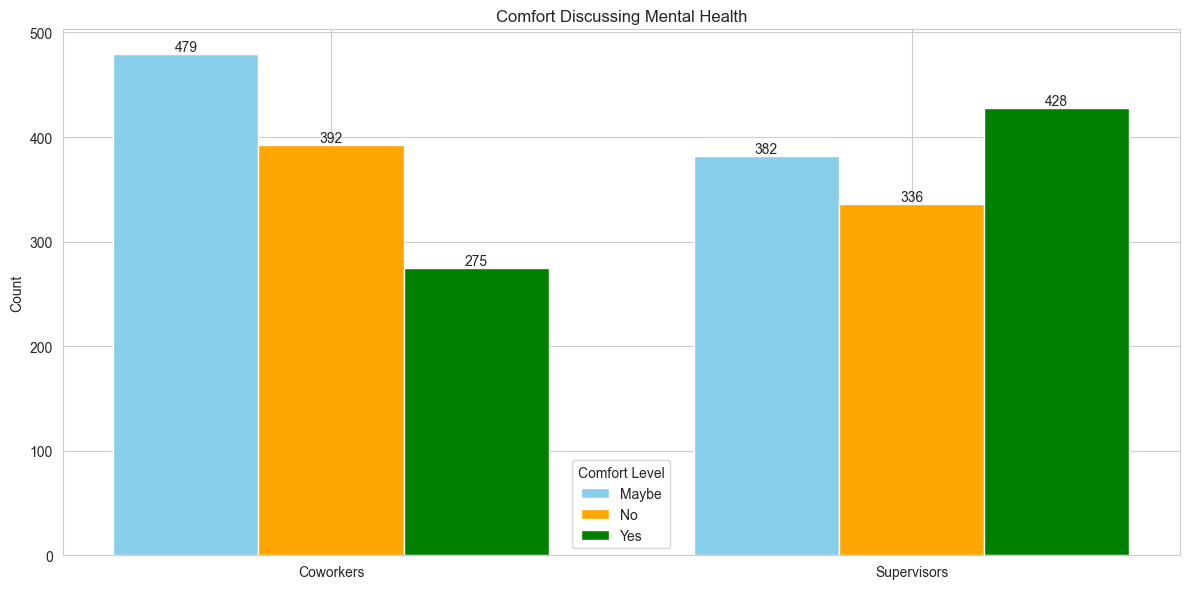

In [843]:
# Assuming df is your DataFrame
# Comfort discussing mental health
comfort_data = df[['Would you feel comfortable discussing a mental health disorder with your coworkers?',
                   'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?']]
comfort_data = comfort_data.melt(var_name='Discuss With', value_name='Comfort Level')
comfort_data['Discuss With'] = comfort_data['Discuss With'].map({
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'Coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'Supervisors'
})

# Count the data
count_data = comfort_data.groupby(['Discuss With', 'Comfort Level']).size().unstack(fill_value=0)

# Set up the plot
plt.figure(figsize=(12, 6))
ax = plt.subplot()

# Define bar width and positions
bar_width = 0.25
r1 = np.arange(len(count_data.index))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the bars
bars1 = ax.bar(r1, count_data['Maybe'], bar_width, label='Maybe', color='skyblue')
bars2 = ax.bar(r2, count_data['No'], bar_width, label='No', color='orange')
bars3 = ax.bar(r3, count_data['Yes'], bar_width, label='Yes', color='green')

# Add labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}',
                ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Customize the plot
plt.title('Comfort Discussing Mental Health')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks([r + bar_width for r in range(len(count_data.index))], count_data.index)
plt.legend(title='Comfort Level')

plt.tight_layout()
plt.show()

## Key Observations

1. **Coworker vs Supervisor Comfort**
   - More respondents comfortable discussing with supervisors (428) than coworkers (275)
   - Fewer respondents uncomfortable discussing with supervisors (336) than coworkers (392)

2. **Uncertainty Prevalence**
   - "Maybe" responses highest for both categories (479 for coworkers, 382 for supervisors)
   - Indicates significant uncertainty or context-dependence in comfort levels

3. **Coworker Discussions**
   - Lowest comfort level (275 "Yes" responses)
   - Highest discomfort level (392 "No" responses)

4. **Supervisor Discussions**
   - Highest comfort level (428 "Yes" responses)
   - More balanced distribution among comfort levels

5. **Overall Hesitancy**
   - Combined "No" and "Maybe" responses outnumber "Yes" for both categories

## Implications

- Workplace culture may favor hierarchical communication about mental health
- Significant opportunity to improve peer-to-peer mental health discussions
- Need for clear guidelines on discussing mental health in workplace settings
- Potential benefit in mental health awareness training, especially for peer interactions
- Supervisors might be seen as more capable of addressing or understanding mental health concerns
- High "Maybe" responses suggest situational factors influence comfort levels
- Interventions needed to reduce uncertainty and increase overall comfort in mental health discussions
- Company policies might need review to encourage open dialogue about mental health

In [844]:
# Calculate the number and percentage of missing values
missing_values = df.isnull().sum()
missing_percentages = 100 * df.isnull().sum() / len(df)

# Combine into a table
missing_table = pd.concat([missing_values, missing_percentages], axis=1, keys=['Missing Values', 'Percentage Missing'])

# Sort by the number of missing values in descending order
missing_table = missing_table.sort_values('Missing Values', ascending=False)

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Display the table
print(missing_table)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

                                                    Missing Values  \
If you have revealed a mental health issue to a...            1289   
If yes, what percentage of your work time (time...            1229   
Is your primary role within your company relate...            1170   
Do you have medical coverage (private insurance...            1146   
If you have been diagnosed or treated for a men...            1146   
If you have been diagnosed or treated for a men...            1146   
If you have revealed a mental health issue to a...            1146   
Do you know local or online resources to seek h...            1146   
Do you believe your productivity is ever affect...            1146   
If maybe, what condition(s) do you believe you ...            1111   
If yes, what condition(s) have you been diagnos...             865   
Have your observations of how another individua...             776   
If so, what condition(s) were you diagnosed with?              722   
What US state or ter

There are a few columns that we will need to drop because too many values are missing. When the data is cleaned the issue of missing values needs to be addressed.

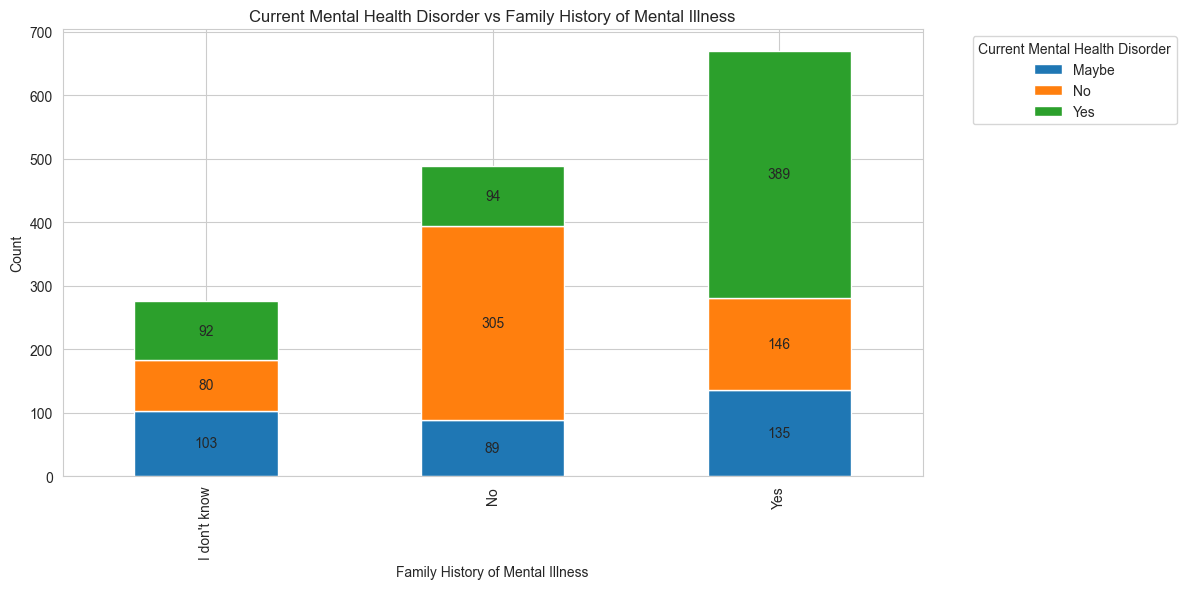

In [845]:
# Create a cross-tabulation of the two variables
cross_tab = pd.crosstab(df['Do you have a family history of mental illness?'], 
                        df['Do you currently have a mental health disorder?'])

# Create a stacked bar chart
ax = cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Current Mental Health Disorder vs Family History of Mental Illness')
plt.xlabel('Family History of Mental Illness')
plt.ylabel('Count')
plt.legend(title='Current Mental Health Disorder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center')

plt.show()

## Key Observations

1. **Family History Impact**
   - 58% of individuals with family history report current mental health disorders
   - Suggests potential genetic or environmental correlation

2. **No Family History**
   - 62.5% without family history report no current mental health disorder
   - 19% still report current disorders, indicating other factors at play

3. **Uncertainty**
   - 275 respondents unsure about family history
   - Even distribution among current disorder status in this group

4. **Prevalence of Mental Health Disorders**
   - Significant presence across all family history categories

5. **Awareness and Diagnosis**
   - "Maybe" responses suggest potential undiagnosed cases or uncertainty

6. **Risk Assessment**
   - Family history appears to be a risk factor, but not deterministic

7. **Need for Mental Health Education**
   - High "I don't know" responses indicate need for better awareness and communication

8. **Complex Relationship**
   - Distribution suggests non-straightforward connection between family history and current mental health

## Implications

- Family history is important but part of a complex picture
- Underscores need for mental health awareness and education
- Highlights importance of accessible mental health resources for all
- Suggests value in considering family history for risk assessments and prevention strategies

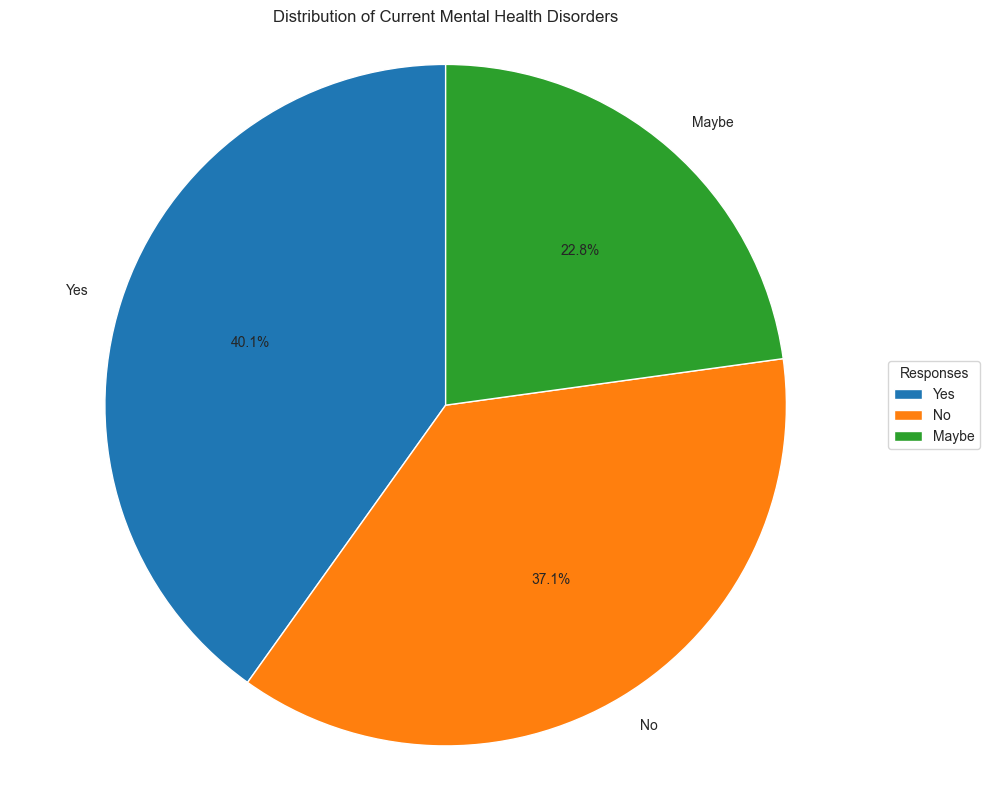

Do you currently have a mental health disorder?
Yes      575
No       531
Maybe    327
Name: count, dtype: int64


In [846]:
# Count the values in the column
value_counts = df['Do you currently have a mental health disorder?'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Current Mental Health Disorders')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add a legend
plt.legend(title="Responses", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# Print the exact counts
print(value_counts)

## Key Observations

1. **Prevalence of Mental Health Disorders**
   - 40.1% (575) of respondents currently have a mental health disorder
   - This represents a significant portion of the surveyed tech workforce

2. **Absence of Mental Health Disorders**
   - 37.1% (531) of respondents do not currently have a mental health disorder
   - Only slightly lower than those reporting a disorder

3. **Uncertainty**
   - 22.8% (327) of respondents are unsure if they currently have a mental health disorder
   - Indicates a substantial level of uncertainty or potential undiagnosed cases

4. **Overall Distribution**
   - The distribution is relatively balanced, with a slight lean towards having or potentially having a mental health disorder (62.9% combined "Yes" and "Maybe")

## Implications

1. **Workplace Support Needs**
   - With over 40% of respondents reporting a mental health disorder, there's a clear need for robust mental health support in tech workplaces

2. **Mental Health Awareness**
   - The high percentage of "Maybe" responses suggests a need for better mental health education and resources for self-assessment

3. **Potential Underreporting**
   - The actual prevalence of mental health disorders may be higher, considering the "Maybe" responses

4. **Resource Allocation**
   - Companies should consider allocating significant resources to mental health support, given that a majority of employees either have or may have a mental health disorder

5. **Stigma Reduction**
   - The openness in reporting mental health disorders (40.1% "Yes") might indicate reduced stigma, but there's still room for improvement

6. **Preventive Measures**
   - With 37.1% not reporting a disorder, there's an opportunity for preventive mental health measures to maintain wellbeing

7. **Diagnostic Support**
   - The 22.8% uncertainty rate suggests a need for better access to mental health diagnostics and professional consultations

8. **Industry-Wide Consideration**
   - The high prevalence of mental health disorders may be an industry-wide issue in tech, calling for sector-level initiatives

This data underscores the importance of comprehensive mental health strategies in tech companies, including support, education, and destigmatization efforts.

## Feature Engineering - Data Preprocessing
we need to clean some columns before we continue. this includes renaming all columns for easier handling, such that we dont need to use the complete questions. standardizing age column, mental health condition column and convert all categorical columns to binary numerical columns.

In [847]:
# Rename all columns so they are handled more easily
# Define a dictionary to map old column names to new ones
column_map = {
    'Are you self-employed?': 'self_employed',
    'How many employees does your company or organization have?': 'company_size',
    'Is your employer primarily a tech company/organization?': 'tech_company',
    'Is your primary role within your company related to tech/IT?': 'tech_role',
    'Does your employer provide mental health benefits as part of healthcare coverage?': 'emp_mh_benefits',
    'Do you know the options for mental health care available under your employer-provided coverage?': 'know_mh_options',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?': 'emp_discussed_mh',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?': 'mh_resources',
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?': 'anonymity_protected',
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:': 'leave_difficulty',
    'Do you think that discussing a mental health disorder with your employer would have negative consequences?': 'neg_consequences_mental_discuss',
    'Do you think that discussing a physical health issue with your employer would have negative consequences?': 'neg_consequences_physical_discuss',
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'comfortable_discuss_coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'comfortable_discuss_supervisors',
    'Do you feel that your employer takes mental health as seriously as physical health?': 'emp_mh_seriously',
    'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?': 'observed_neg_consequences',
    'Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?': 'mh_coverage',
    'Do you know local or online resources to seek help for a mental health disorder?': 'know_local_online_resources',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?': 'reveal_clients',
    'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?': 'neg_impact_reveal_clients',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?': 'reveal_coworkers',
    'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?': 'neg_impact_reveal_coworkers',
    'Do you believe your productivity is ever affected by a mental health issue?': 'mh_affects_productivity',
    'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?': 'productivity_affected_percent',
    'Do you have previous employers?': 'previous_emp',
    'Have your previous employers provided mental health benefits?': 'previous_emp_mh_benefits',
    'Were you aware of the options for mental health care provided by your previous employers?': 'aware_prev_mh_options',
    'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?': 'prev_employers_discussed_mh',
    'Did your previous employers provide resources to learn more about mental health issues and how to seek help?': 'prev_mh_resources',
    'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?': 'prev_anonymity_protected',
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?': 'prev_neg_consequences_discuss',
    'Do you think that discussing a physical health issue with previous employers would have negative consequences?': 'prev_neg_consequences_physical',
    'Would you have been willing to discuss a mental health issue with your previous co-workers?': 'prev_comfortable_discuss_coworkers',
    'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?': 'prev_comfortable_discuss_supervisors',
    'Did you feel that your previous employers took mental health as seriously as physical health?': 'prev_emp_mh_seriously',
    'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?': 'prev_observed_neg_consequences',
    'Would you be willing to bring up a physical health issue with a potential employer in an interview?': 'mention_discuss_physical_interview',
    'Why or why not?': 'mention_discuss_physical_interview_reason',
    'Would you bring up a mental health issue with a potential employer in an interview?': 'mention_discuss_mh_interview',
    'Why or why not?.1': 'mention_discuss_mh_interview_reason',
    'Do you feel that being identified as a person with a mental health issue would hurt your career?': 'mh_hurt_career',
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?': 'coworkers_view_negatively',
    'How willing would you be to share with friends and family that you have a mental illness?': 'willing_share_friends_family',
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?': 'experienced_unsupportive_response',
    'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?': 'others_experience_affect_you',
    'Do you have a family history of mental illness?': 'family_history',
    'Have you had a mental health disorder in the past?': 'past_mh_disorder',
    'Do you currently have a mental health disorder?': 'current_mh_disorder',
    'If yes, what condition(s) have you been diagnosed with?': 'diagnosed_conditions',
    'If maybe, what condition(s) do you believe you have?': 'believed_conditions',
    'Have you been diagnosed with a mental health condition by a medical professional?': 'professionally_diagnosed',
    'If so, what condition(s) were you diagnosed with?': 'professional_diagnoses',
    'Have you ever sought treatment for a mental health issue from a mental health professional?': 'sought_treatment',
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?': 'work_interference_treated',
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?': 'work_interference_untreated',
    'What is your age?': 'age',
    'What is your gender?': 'gender',
    'What country do you live in?': 'country',
    'What US state or territory do you live in?': 'state',
    'What country do you work in?': 'work_country',
    'What US state or territory do you work in?': 'work_state',
    'Which of the following best describes your work position?': 'position',
    'Do you work remotely?': 'remote_work'
}

# Rename the columns
df.rename(columns=column_map, inplace=True)

In [848]:
# Clean up the gender column
male_values = [
    'male', 'Male ', 'M', 'm', 'man', 'Cis male',
    'Male.', 'Male (cis)', 'Man', 'Sex is male',
    'cis male', 'Malr', 'Dude', "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
    'mail', 'M|', 'male ', 'Cis Male', 'Male (trans, FtM)',
    'cisdude', 'cis man', 'MALE'
]

female_values = [
    'female', 'I identify as female.', 'female ',
    'Female assigned at birth ', 'F', 'Woman', 'fm', 'f',
    'Cis female', 'Transitioned, M2F', 'Female or Multi-Gender Femme',
    'Female ', 'woman', 'female/woman', 'Cisgender Female', 
    'mtf', 'fem', 'Female (props for making this a freeform field, though)',
    ' Female', 'Cis-woman', 'AFAB', 'Transgender woman',
    'Cis female '
]

other_values = [
    'Bigender', 'non-binary,', 'Genderfluid (born female)',
    'Other/Transfeminine', 'Androgynous', 'male 9:1 female, roughly',
    'nb masculine', 'genderqueer', 'Human', 'Genderfluid',
    'Enby', 'genderqueer woman', 'Queer', 'Agender', 'Fluid',
    'Genderflux demi-girl', 'female-bodied; no feelings about gender',
    'non-binary', 'Male/genderqueer', 'Nonbinary', 'Other', 'none of your business',
    'Unicorn', 'human', 'Genderqueer'
]

df['gender'] = df['gender'].replace(male_values, 'Male')
df['gender'] = df['gender'].replace(female_values, 'Female')
df['gender'] = df['gender'].replace(other_values, 'Others')

# replace missing values for three rows for gender with the mode Male
df['gender'] = df['gender'].replace(np.nan, 'Male')

# I later decided to drop "Other" gender
df = df[df['gender']!= 'Others']

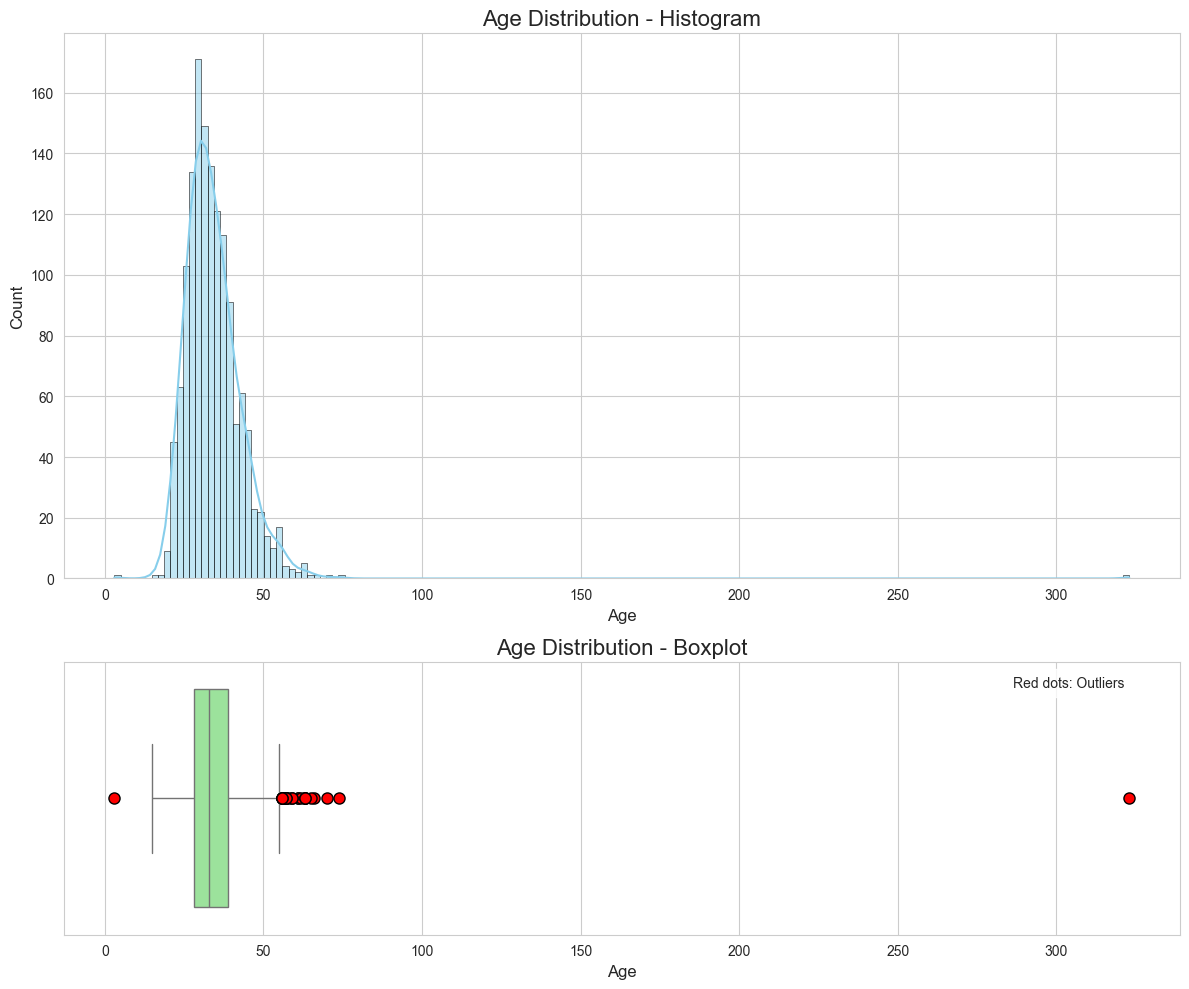

In [849]:
# Set the style for the plot
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])

# Histogram plot
sns.histplot(data=df, x='age', kde=True, color='skyblue', edgecolor='black', ax=ax1)
ax1.set_title('Age Distribution - Histogram', fontsize=16)
ax1.set_xlabel('Age', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

# Boxplot with marked outliers
sns.boxplot(data=df, x='age', color='lightgreen', ax=ax2, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8, 'markeredgecolor': 'black'})
ax2.set_title('Age Distribution - Boxplot', fontsize=16)
ax2.set_xlabel('Age', fontsize=12)

# Add a text annotation explaining the outliers
ax2.text(0.95, 0.95, 'Red dots: Outliers', transform=ax2.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [850]:
# Find relevant outliers to replace them
# Get the top 5 max values
top_10 = df['age'].nlargest(10)

# Get the bottom 5 min values
bottom_10 = df['age'].nsmallest(10)

print("Top 10 maximum ages:")
print(top_10)

print("\nBottom 10 minimum ages:")
print(bottom_10)

Top 10 maximum ages:
564     323
1117     74
1221     70
701      66
885      65
308      63
745      63
900      63
1224     63
591      62
Name: age, dtype: int64

Bottom 10 minimum ages:
656     3
808    15
93     17
76     19
559    19
736    19
754    19
282    20
528    20
771    20
Name: age, dtype: int64


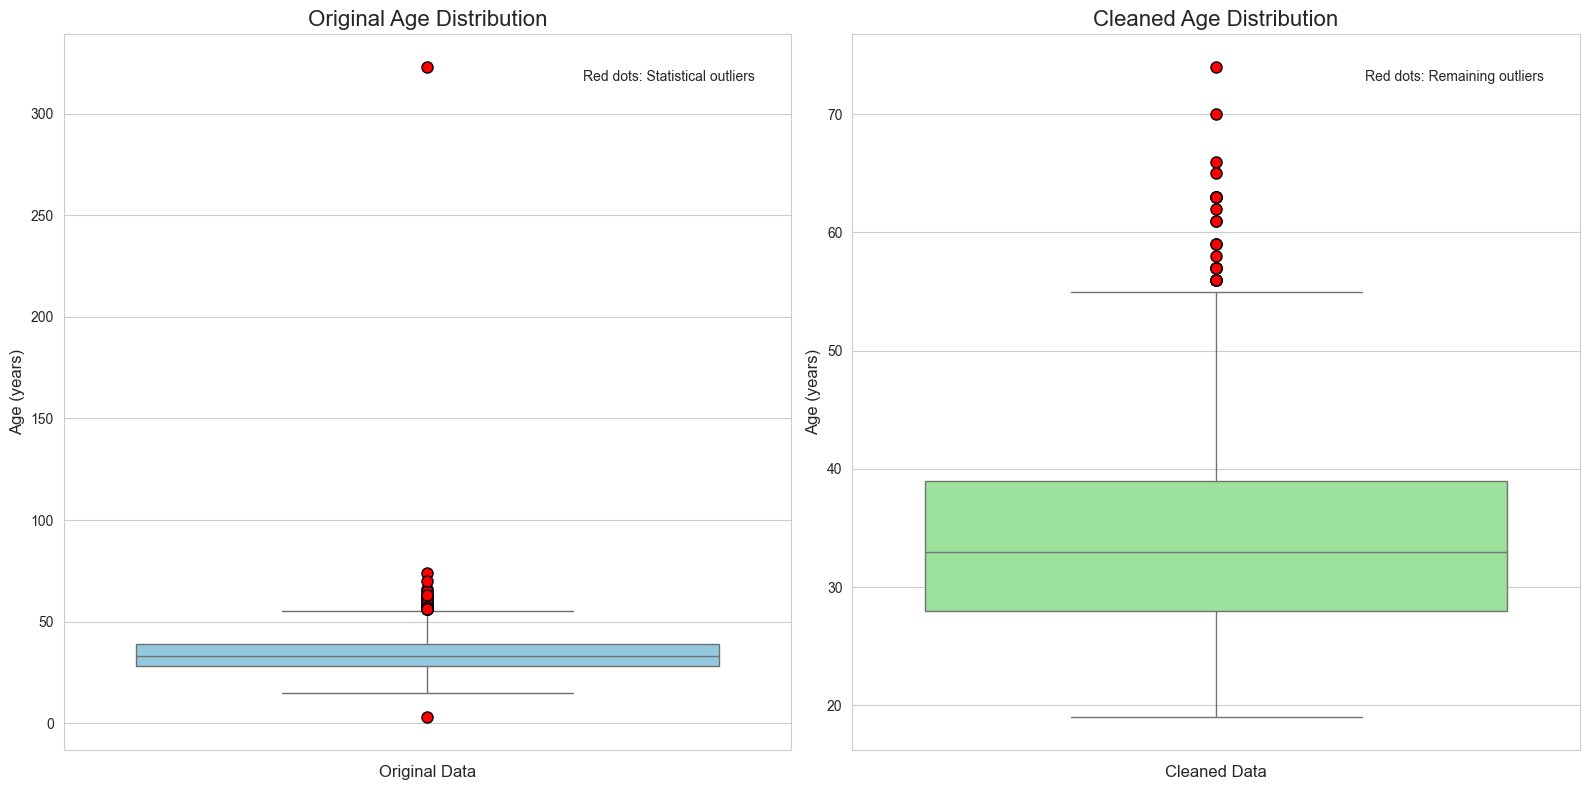


Descriptive Statistics - Original Age Distribution:
count    1404.000000
mean       34.341168
std        11.225911
min         3.000000
25%        28.000000
50%        33.000000
75%        39.000000
max       323.000000
Name: age, dtype: float64

Descriptive Statistics - Cleaned Age Distribution:
count    1404.000000
mean       34.180199
std         8.088842
min        19.000000
25%        28.000000
50%        33.000000
75%        39.000000
max        74.000000
Name: age, dtype: float64


In [851]:
# Create a copy of the DataFrame to avoid modifying the original
df_cleaned = df.copy()

# List of outlier values identified in the age column
outliers = [323, 99, 3, 15, 17]

# Calculate the median of non-outlier ages using boolean indexing
median_age = df_cleaned[~df_cleaned['age'].isin(outliers)]['age'].median()

# Replace outliers and missing values with the calculated median
df_cleaned['age'] = df_cleaned['age'].replace(outliers, median_age)
df_cleaned['age'] = df_cleaned['age'].fillna(median_age)

# Create a figure with two subplots for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Visualize original data distribution
sns.boxplot(data=df, y='age', color='skyblue', ax=ax1, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 
                       'markersize': 8, 'markeredgecolor': 'black'})
ax1.set_title('Original Age Distribution', fontsize=16)
ax1.set_ylabel('Age (years)', fontsize=12)
ax1.set_xlabel('Original Data', fontsize=12)

# Add annotation for original data
ax1.text(0.95, 0.95, 'Red dots: Statistical outliers', 
         transform=ax1.transAxes, 
         verticalalignment='top', 
         horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Visualize cleaned data distribution
sns.boxplot(data=df_cleaned, y='age', color='lightgreen', ax=ax2, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 
                       'markersize': 8, 'markeredgecolor': 'black'})
ax2.set_title('Cleaned Age Distribution', fontsize=16)
ax2.set_ylabel('Age (years)', fontsize=12)
ax2.set_xlabel('Cleaned Data', fontsize=12)

# Add annotation for cleaned data
ax2.text(0.95, 0.95, 'Red dots: Remaining outliers', 
         transform=ax2.transAxes, 
         verticalalignment='top', 
         horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Optimize layout
plt.tight_layout()

# Display the visualization
plt.show()

# Display descriptive statistics for comparison
print("\nDescriptive Statistics - Original Age Distribution:")
print(df['age'].describe())
print("\nDescriptive Statistics - Cleaned Age Distribution:")
print(df_cleaned['age'].describe())

# Update the original DataFrame for subsequent analysis
df = df_cleaned

I've created four new binary columns:

age_0_25: 1 if in youngest quartile (≤25th percentile), 0 otherwise
age_25_50: 1 if in second quartile (25th-50th percentile), 0 otherwise
age_50_75: 1 if in third quartile (50th-75th percentile), 0 otherwise
age_75_100: 1 if in oldest quartile (>75th percentile), 0 otherwise

Each person will have a 1 in exactly one of these columns and 0 in all others. This creates mutually exclusive categories with approximately equal distribution (≈25% in each group).

In [852]:
df.head()

,self_employed,company_size,tech_company,tech_role,emp_mh_benefits,know_mh_options,emp_discussed_mh,mh_resources,anonymity_protected,leave_difficulty,...,work_interference_treated,work_interference_untreated,age,gender,country,state,work_country,work_state,position,remote_work
0,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,...,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
1,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,...,Rarely,Sometimes,29,Male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
2,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,...,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Sometimes,Sometimes,43,Male,United Kingdom,NaN,United Kingdom,NaN,Supervisor/Team Lead,Sometimes
4,0,6-25,0.0,1.0,Yes,Yes,No,No,No,Neither easy nor difficult,...,Sometimes,Sometimes,43,Female,United States of America,Illinois,United States of America,Illinois,Executive Leadership|Supervisor/Team Lead|Dev ...,Sometimes


In [853]:
# List of all unique conditions
conditions = [
    'Anxiety Disorder',
    'Mood Disorder',
    'Attention Deficit Hyperactivity Disorder',
    'Post-traumatic Stress Disorder',
    'Stress Response Syndromes',
    'Personality Disorder',
    'Obsessive-Compulsive Disorder',
    'Eating Disorder',
    'Substance Use Disorder',
    'Addictive Disorder',
    'Psychotic Disorder',
    'Dissociative Disorder',
    'Autism',
    'Asperger Syndrome',
    'Gender Identity Disorder',
    'Intimate Disorder',
    'Traumatic Brain Injury',
    'Seasonal Affective Disorder',
    'Burn out',
    'Depersonalization Disorder',
    'Tinnitus',
    'Suicidal Ideation'
]

# Function to check if a condition is present
# For PDD-NOS we also use Autism
def has_condition(row, condition):
    if pd.isna(row):
        return 0
    if condition == 'Autism':
        return 1 if any(c in row for c in ['Autism', 'PDD-NOS']) else 0
    return 1 if condition in row else 0

# Function to check if any condition is present
def has_any_condition(row):
    if pd.isna(row):
        return 0
    for condition in conditions:
        if condition == 'Autism' and any(c in row for c in ['Autism', 'PDD-NOS']):
            return 1
        elif condition in row:
            return 1
    return 0

# Create binary columns for each condition, that has been professionally diagnosed
for condition in conditions:
    df[f'Has_{condition.replace(" ", "_")}'] = df['diagnosed_conditions'].apply(lambda x: has_condition(x, condition))

# Create a single binary column indicating if the person has any condition
df['has_condition'] = df['diagnosed_conditions'].apply(has_any_condition)

# Get list of columns to potentially drop
columns_to_check = [col for col in df.columns if col.startswith('Has_')]

# Find columns with all zeros
columns_to_drop = [col for col in columns_to_check if df[col].max() == 0]

# Drop two columns that are all zeros, but were not catched
df = df.drop(columns=['Has_Intimate_Disorder', 'Has_Burn_out'])

# For experimental purposes, let's also drop the columns that indicate if the person has a specific condition'
# Drop the individual condition columns if they exist
columns_to_drop = [col for col in df.columns if col.startswith('Has_')]
df = df.drop(columns=columns_to_drop, errors='ignore')

#### drop columns and rows that we most likely wont need in our analysis

mental health conditions probably depend highly on external factos between countries. as we want to focus on the employer effects it does make sense to only look at one country to have comparable individuals

In [854]:
# drop all rows that are not USA
df=df[df['work_country']=='United States of America']
df=df.reset_index(drop=True)

# drop columns that are not relevant for our analysis
df=df.drop(columns=['country', 'state', 'previous_emp', 'previous_emp_mh_benefits', 'aware_prev_mh_options','prev_employers_discussed_mh', 'prev_mh_resources', 'prev_anonymity_protected', 'prev_neg_consequences_discuss', 'prev_neg_consequences_physical', 'prev_comfortable_discuss_coworkers', 'prev_comfortable_discuss_supervisors', 'prev_emp_mh_seriously', 'prev_observed_neg_consequences', 'willing_share_friends_family', 'reveal_clients', 'neg_impact_reveal_clients', 'reveal_coworkers', 'neg_impact_reveal_coworkers', 'neg_consequences_physical_discuss', 'work_interference_treated', 'work_interference_untreated' ])

# keep only the current mental health condition (not the ones the participants "maybe" have and not the ones that were diagnosed in the past)
df=df.drop(columns=['believed_conditions','professionally_diagnosed','professional_diagnoses','diagnosed_conditions','past_mh_disorder', 'current_mh_disorder'])

# drop free text columns
df=df.drop(columns=['mention_discuss_physical_interview_reason','mention_discuss_mh_interview_reason'])

# drop all rows where self_employed is 1, because from HR perspective only "normal" employees are relevant
df=df[df['self_employed']==0]
df=df.drop(columns=['self_employed'])
df=df.reset_index(drop=True)

# drop the columns that only have values for self-employed employees
df=df.drop(columns=['mh_coverage','know_local_online_resources','mh_affects_productivity', 'productivity_affected_percent'])

# drop work_state because there is no value for other countries than USA and we can not fill in missing values
df=df.drop(columns=['work_state'])

In [855]:
# Calculate percentage of missing values
missing_percentages = df.isnull().mean() * 100

# Sort the percentages in descending order and filter out columns with no missing values
missing_percentages_sorted = missing_percentages[missing_percentages > 0].sort_values(ascending=False)

print("\nPercentage of missing values (sorted in descending order):")
for col, pct in missing_percentages_sorted.items():
    print(f"{col}: {pct:.2f}%")


Percentage of missing values (sorted in descending order):
tech_role: 76.28%
others_experience_affect_you: 55.68%
know_mh_options: 3.84%
experienced_unsupportive_response: 3.69%


In [856]:
# drop columns with more than 50% missing values
df = df.drop(columns=['tech_role','others_experience_affect_you'])

In [857]:
# Define mapping dictionary for company sizes to ordinal values
company_size_mapping = {
    '1-5': 1,
    '6-25': 2,
    '26-100': 3,
    '100-500': 4,
    '500-1000': 5,
    '>1000': 6,
    'More than 1000': 6  # Including both possible versions of 1000+
}

# Function to convert company size to ordinal value
def encode_company_size(size):
    if pd.isna(size):
        return 0  # Handle missing values
    return company_size_mapping.get(size, 0)  # Return 0 for any unmapped values

# Create new ordinal column
df['company_size_ordinal'] = df['company_size'].apply(encode_company_size)

# Drop original company_size column
df = df.drop(columns=['company_size'])

In [858]:
# Create binary columns for emp_mh_benefits column
# Define emp_mh_benefits categories
emp_mh_benefits_categories = [
    "Yes",
    "I don't know",
    "No",
    "Not eligible for coverage / N/A"
]

# Function to check emp_mh_benefits category
def emp_mh_benefits_category(value, category):
    if pd.isna(value):
        return 0
    return 1 if value == category else 0

# Function to create a valid column name
def create_column_name(category):
    return "emp_mh_benefits_" + category.replace(' ', '_').replace('/', '').replace("'", "")

# Create binary columns for each emp_mh_benefits category
for category in emp_mh_benefits_categories:
    column_name = create_column_name(category)
    df[column_name] = df['emp_mh_benefits'].apply(lambda x: emp_mh_benefits_category(x, category))

# Drop the original emp_mh_benefits column
df = df.drop(columns=['emp_mh_benefits'])

# Drop last category column to avoid multicollinearity
df = df.drop(columns=['emp_mh_benefits_Not_eligible_for_coverage__NA'])

#### convert know_mh_benefits to binary column and fill missing values with most frequent value

In [859]:
# Define know_mh_options categories
know_mh_options_categories = [
    "Yes",
    "I am not sure",
    "No"
]

# Create SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values
df['know_mh_options'] = imputer.fit_transform(df[['know_mh_options']]).ravel()

# Function to check know_mh_options category
def know_mh_options_category(value, category):
    return 1 if value == category else 0

# Create binary columns for each know_mh_options category
for category in know_mh_options_categories:
    column_name = f"know_mh_options_{category.replace(' ', '_')}"
    df[column_name] = df['know_mh_options'].apply(lambda x: know_mh_options_category(x, category))

# Drop the original know_mh_options column
df = df.drop(columns=['know_mh_options'])

# Drop last category column to avoid multicollinearity
df = df.drop(columns=['know_mh_options_I_am_not_sure'])

#### create binary column for all other categorical columns that are easy to handle

In [860]:
def safe_column_name(name):
    return re.sub(r'\W+', '_', str(name))

def create_binary_columns(df, column_name):
    # Get unique values
    unique_values = df[column_name].dropna().unique()
    
    # Create binary columns for ALL categories
    new_columns = []
    for value in unique_values:
        new_column_name = f"{column_name}_{safe_column_name(value)}"
        df[new_column_name] = (df[column_name] == value).astype(int)
        new_columns.append(new_column_name)
    
    # Drop the original column
    df = df.drop(columns=[column_name])
    
    return df

# List of columns to convert
columns_to_convert = [
    'emp_discussed_mh', 'anonymity_protected', 'mh_resources', 'leave_difficulty',
    'neg_consequences_mental_discuss',
    'comfortable_discuss_coworkers', 'comfortable_discuss_supervisors',
    'emp_mh_seriously', 'observed_neg_consequences', 'mention_discuss_physical_interview',
    'mention_discuss_mh_interview', 'mh_hurt_career', 'coworkers_view_negatively',
    'family_history', 'gender', 'remote_work'
]

# Apply the conversion to each column
for column in columns_to_convert:
    df = create_binary_columns(df, column)

#### simplifiy position columns to IT and Management

In [861]:
def categorize_position(position):
    roles = position.split('|')
    
    it_roles = ['Back-end Developer', 'Front-end Developer', 'DevOps/SysAdmin', 'Dev Evangelist/Advocate']
    management_roles = ['Executive Leadership', 'Supervisor/Team Lead']
    
    is_it_role = 1 if any(role in it_roles for role in roles) else 0
    is_management = 1 if any(role in management_roles for role in roles) else 0
    
    return is_it_role, is_management

# Categorize positions into IT and Management roles
df['Is_IT_Role'], df['Is_Management'] = zip(*df['position'].apply(categorize_position))

# Drop the original 'position' column
df = df.drop(columns=['position'])

#### convert expoerience_unsupportive_response column

In [862]:
# Define experienced_unsupportive_response categories
experienced_unsupportive_response_categories = [
    "No",
    "Maybe/Not sure",
    "Yes"
]

# Create SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values
df['experienced_unsupportive_response'] = imputer.fit_transform(df[['experienced_unsupportive_response']]).ravel()

# Combine "Yes" categories
df['experienced_unsupportive_response'] = df['experienced_unsupportive_response'].replace({
    'Yes, I observed': 'Yes',
    'Yes, I experienced': 'Yes'
})

# Function to check experienced_unsupportive_response category
def experienced_unsupportive_response_category(value, category):
    return 1 if value == category else 0

# Create binary columns for each experienced_unsupportive_response category
for category in experienced_unsupportive_response_categories:
    column_name = f"experienced_unsupportive_response_{category.replace('/', '_')}"
    df[column_name] = df['experienced_unsupportive_response'].apply(lambda x: experienced_unsupportive_response_category(x, category))

# Drop the original experienced_unsupportive_response column
df = df.drop(columns=['experienced_unsupportive_response'])


# Drop one catgeory column to avoid multicollinearity
df = df.drop(columns=['experienced_unsupportive_response_Maybe_Not sure'])

In [863]:
# Convert tech_company column to integer type
df['tech_company'] = df['tech_company'].astype(int)

#### categorize countries into continents for simplicity and take the loss on granularity

In [864]:
# Define a mapping of countries to continents
country_to_continent = {
    'United Kingdom': 'Europe',
    'United States of America': 'North America',
    'Canada': 'North America',
    'Germany': 'Europe',
    'Netherlands': 'Europe',
    'Australia': 'Oceania',
    'France': 'Europe',
    'Belgium': 'Europe',
    'Brazil': 'South America',
    'Denmark': 'Europe',
    'Sweden': 'Europe',
    'Russia': 'Europe',
    'Spain': 'Europe',
    'India': 'Asia',
    'United Arab Emirates': 'Asia',
    'Mexico': 'North America',
    'Switzerland': 'Europe',
    'Norway': 'Europe',
    'Argentina': 'South America',
    'Ireland': 'Europe',
    'Italy': 'Europe',
    'Colombia': 'South America',
    'Czech Republic': 'Europe',
    'Vietnam': 'Asia',
    'Finland': 'Europe',
    'Bulgaria': 'Europe',
    'South Africa': 'Africa',
    'Slovakia': 'Europe',
    'Bangladesh': 'Asia',
    'Pakistan': 'Asia',
    'New Zealand': 'Oceania',
    'Afghanistan': 'Asia',
    'Poland': 'Europe',
    'Iran': 'Asia',
    'Hungary': 'Europe',
    'Israel': 'Asia',
    'Japan': 'Asia',
    'Ecuador': 'South America',
    'Bosnia and Herzegovina': 'Europe',
    'Austria': 'Europe',
    'Romania': 'Europe',
    'Chile': 'South America',
    'Estonia': 'Europe',
    'Other': 'Other'
}

# Function to map country to continent
def country_to_continent_map(country):
    return country_to_continent.get(country, 'Other')

# Apply the mapping to create a new 'continent' column
df['continent'] = df['work_country'].apply(country_to_continent_map)

# Create binary columns for each continent
continents = ['Europe', 'North America', 'South America', 'Asia', 'Africa', 'Oceania', 'Other']

for continent in continents:
    column_name = f'continent_{continent.replace(" ", "_")}'
    df[column_name] = (df['continent'] == continent).astype(int)

# Drop the original 'work_country' and 'continent' columns
df = df.drop(['work_country', 'continent'], axis=1)

# Drop one continent columns as long as we only look at USA
df = df.drop(['continent_North_America', 'continent_Europe', 'continent_South_America', 'continent_Asia', 'continent_Africa', 'continent_Oceania', 'continent_Other'], axis=1)

In [865]:
# Create remote_work_yes by combining 'Sometimes' and 'Always'
df['remote_work_yes'] = df['remote_work_Sometimes'] | df['remote_work_Always']

# We can keep remote_work_Never as remote_work_no if needed
df['remote_work_no'] = df['remote_work_Never']

# Drop the original columns
df = df.drop(columns=['remote_work_Sometimes', 'remote_work_Always', 'remote_work_Never'])

Feature Engineering

In [866]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 66 columns):
 #   Column                                                 Non-Null Count  Dtype
---  ------                                                 --------------  -----
 0   tech_company                                           704 non-null    int64
 1   sought_treatment                                       704 non-null    int64
 2   age                                                    704 non-null    int64
 3   has_condition                                          704 non-null    int64
 4   company_size_ordinal                                   704 non-null    int64
 5   emp_mh_benefits_Yes                                    704 non-null    int64
 6   emp_mh_benefits_I_dont_know                            704 non-null    int64
 7   emp_mh_benefits_No                                     704 non-null    int64
 8   know_mh_options_Yes                                    704 non-null   

In [867]:
df.head()

,tech_company,sought_treatment,age,has_condition,company_size_ordinal,emp_mh_benefits_Yes,emp_mh_benefits_I_dont_know,emp_mh_benefits_No,know_mh_options_Yes,know_mh_options_No,...,family_history_No,family_history_I_don_t_know,gender_Male,gender_Female,Is_IT_Role,Is_Management,experienced_unsupportive_response_No,experienced_unsupportive_response_Yes,remote_work_yes,remote_work_no
0,1,1,29,1,2,0,0,1,1,0,...,0,0,1,0,1,0,1,0,0,1
1,0,1,43,1,2,1,0,0,1,0,...,0,0,0,1,1,1,0,1,1,0
2,1,0,30,0,3,0,1,0,0,1,...,1,0,1,0,1,0,1,0,1,0
3,1,1,37,1,6,1,0,0,1,0,...,0,0,0,1,1,0,0,1,1,0
4,0,1,44,1,3,0,1,0,0,1,...,0,0,0,1,1,0,0,1,1,0


In [868]:
# 1. Create composite scores (keeping original function)
def create_mental_health_scores(data):
    """
    Creates composite scores using weighted components.
    """
    # Support Score Components
    support_components = {
        'emp_mh_benefits_Yes': (2.0, data['emp_mh_benefits_Yes']),
        'mh_resources_Yes': (1.5, data['mh_resources_Yes']),
        'know_mh_options_Yes': (1.0, data['know_mh_options_Yes']),
        'emp_discussed_mh_Yes': (1.0, data['emp_discussed_mh_Yes']),
        'emp_mh_seriously_Yes': (1.5, data['emp_mh_seriously_Yes']),
        'anonymity_protected_Yes': (1.5, data['anonymity_protected_Yes']),
        'leave_difficulty_Very_easy': (1.0, data['leave_difficulty_Very_easy']),
        'leave_difficulty_Somewhat_easy': (0.5, data['leave_difficulty_Somewhat_easy']),
        'leave_difficulty_Neither_easy_nor_difficult': (0.25, data['leave_difficulty_Neither_easy_nor_difficult'])
    }

    # Stigma Score Components
    stigma_components = {
        'neg_consequences_mental_discuss_Yes': (2.0, data['neg_consequences_mental_discuss_Yes']),
        'mh_hurt_career_Yes_I_think_it_would': (2.0, data['mh_hurt_career_Yes_I_think_it_would']),
        'mh_hurt_career_Maybe': (1.0, data['mh_hurt_career_Maybe']),
        'coworkers_view_negatively_Yes_I_think_they_would': (1.5, data['coworkers_view_negatively_Yes_I_think_they_would']),
        'coworkers_view_negatively_Maybe': (0.75, data['coworkers_view_negatively_Maybe']),
        'experienced_unsupportive_response_Yes': (2.0, data['experienced_unsupportive_response_Yes'])
    }

    # Disclosure Score Components
    disclosure_components = {
        'mention_discuss_mh_interview_Yes': (2.0, data['mention_discuss_mh_interview_Yes']),
        'mention_discuss_physical_interview_Yes': (1.5, data['mention_discuss_physical_interview_Yes']),
        'comfortable_discuss_coworkers_Yes': (1.5, data['comfortable_discuss_coworkers_Yes']),
        'comfortable_discuss_supervisors_Yes': (2.0, data['comfortable_discuss_supervisors_Yes'])
    }

    # Resource Score Components
    resource_components = {
        'emp_mh_benefits_Yes': (2.0, data['emp_mh_benefits_Yes']),
        'know_mh_options_Yes': (1.5, data['know_mh_options_Yes']),
        'mh_resources_Yes': (1.5, data['mh_resources_Yes']),
        'leave_difficulty_Very_easy': (1.0, data['leave_difficulty_Very_easy']),
        'leave_difficulty_Somewhat_easy': (0.5, data['leave_difficulty_Somewhat_easy'])
    }

    def calculate_weighted_score(components):
        weighted_sum = sum(weight * value for weight, value in components.values())
        max_possible = sum(weight for weight, _ in components.values())
        return (weighted_sum / max_possible) * 100

    return pd.DataFrame({
        'support_score': calculate_weighted_score(support_components),
        'stigma_score': calculate_weighted_score(stigma_components),
        'disclosure_score': calculate_weighted_score(disclosure_components),
        'resource_score': calculate_weighted_score(resource_components)
    })

# 2. Create and analyze scores
scores = create_mental_health_scores(df)

# 3. Combine scores with original variables
features_for_clustering = df[[
    'sought_treatment', 'age',
    'has_condition', 'company_size_ordinal', 'family_history_Yes', 'gender_Male', 'remote_work_yes',
    'Is_IT_Role', 'Is_Management'
]].copy()

# Add the composite scores
features_for_clustering = pd.concat([features_for_clustering, scores], axis=1)


In [869]:
features_for_clustering.info()
features_for_clustering.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sought_treatment      704 non-null    int64  
 1   age                   704 non-null    int64  
 2   has_condition         704 non-null    int64  
 3   company_size_ordinal  704 non-null    int64  
 4   family_history_Yes    704 non-null    int64  
 5   gender_Male           704 non-null    int64  
 6   remote_work_yes       704 non-null    int64  
 7   Is_IT_Role            704 non-null    int64  
 8   Is_Management         704 non-null    int64  
 9   support_score         704 non-null    float64
 10  stigma_score          704 non-null    float64
 11  disclosure_score      704 non-null    float64
 12  resource_score        704 non-null    float64
dtypes: float64(4), int64(9)
memory usage: 71.6 KB


,sought_treatment,age,has_condition,company_size_ordinal,family_history_Yes,gender_Male,remote_work_yes,Is_IT_Role,Is_Management,support_score,stigma_score,disclosure_score,resource_score
0,1,29,1,2,1,1,0,1,0,68.292683,0.000000,28.571429,53.846154
1,1,43,1,2,1,0,1,1,1,31.707317,72.972973,0.000000,53.846154
2,0,30,0,3,0,1,1,1,0,19.512195,21.621622,78.571429,7.692308
3,1,37,1,6,1,0,1,1,0,68.292683,40.540541,28.571429,92.307692
4,1,44,1,3,1,0,1,1,0,0.000000,54.054054,21.428571,0.000000


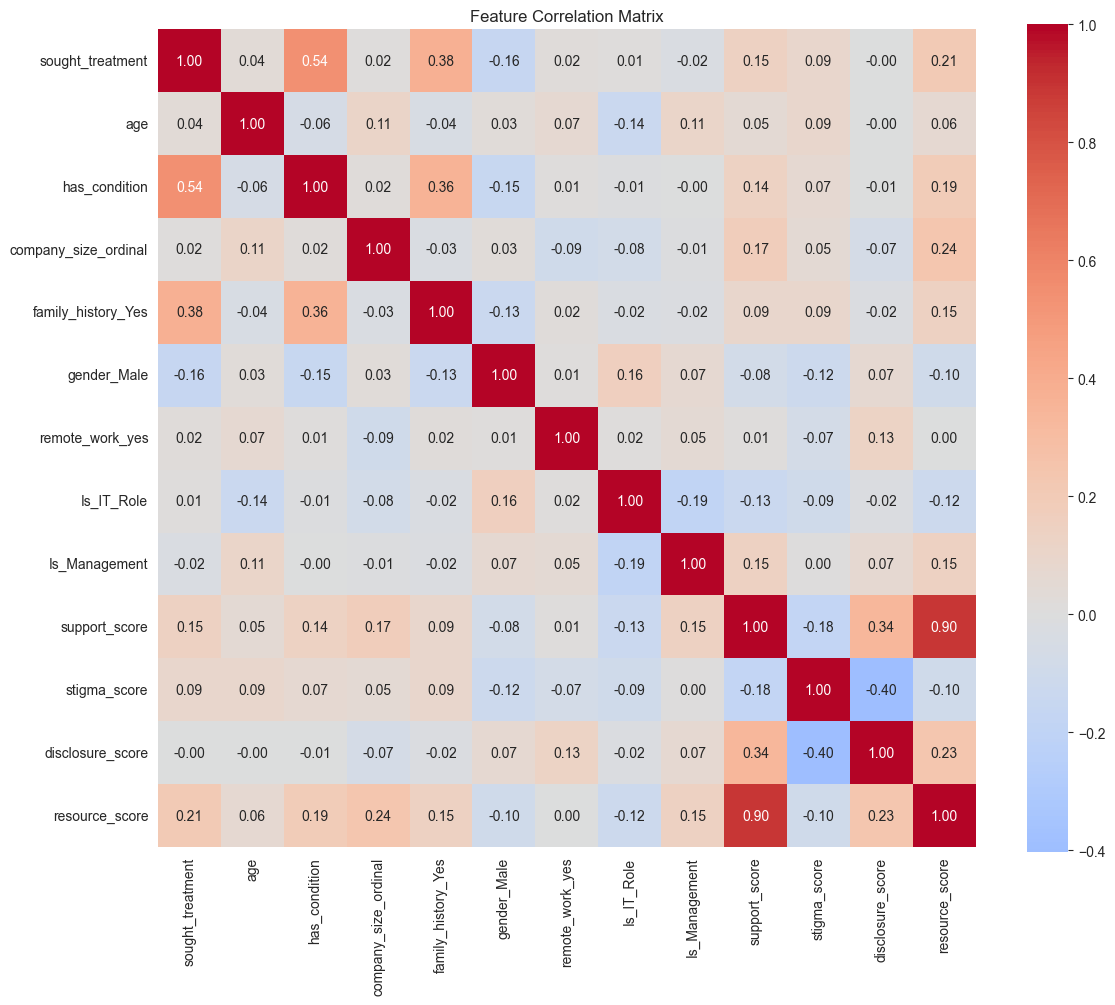


Highly correlated feature pairs (correlation > 0.8):
support_score - resource_score: 0.896
resource_score - support_score: 0.896


In [870]:
# Create correlation matrix
correlation_matrix = features_for_clustering.corr()

# Create heatmap visualization using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Show 2 decimal places
            square=True)  # Make cells square
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs (above 0.8 for example)
threshold = 0.8
high_corr = np.where(np.abs(correlation_matrix) > threshold)
high_corr = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x,y]) 
             for x, y in zip(*high_corr) if x != y]  # Exclude self-correlations

print("\nHighly correlated feature pairs (correlation > 0.8):")
for feat1, feat2, corr in high_corr:
    print(f"{feat1} - {feat2}: {corr:.3f}")

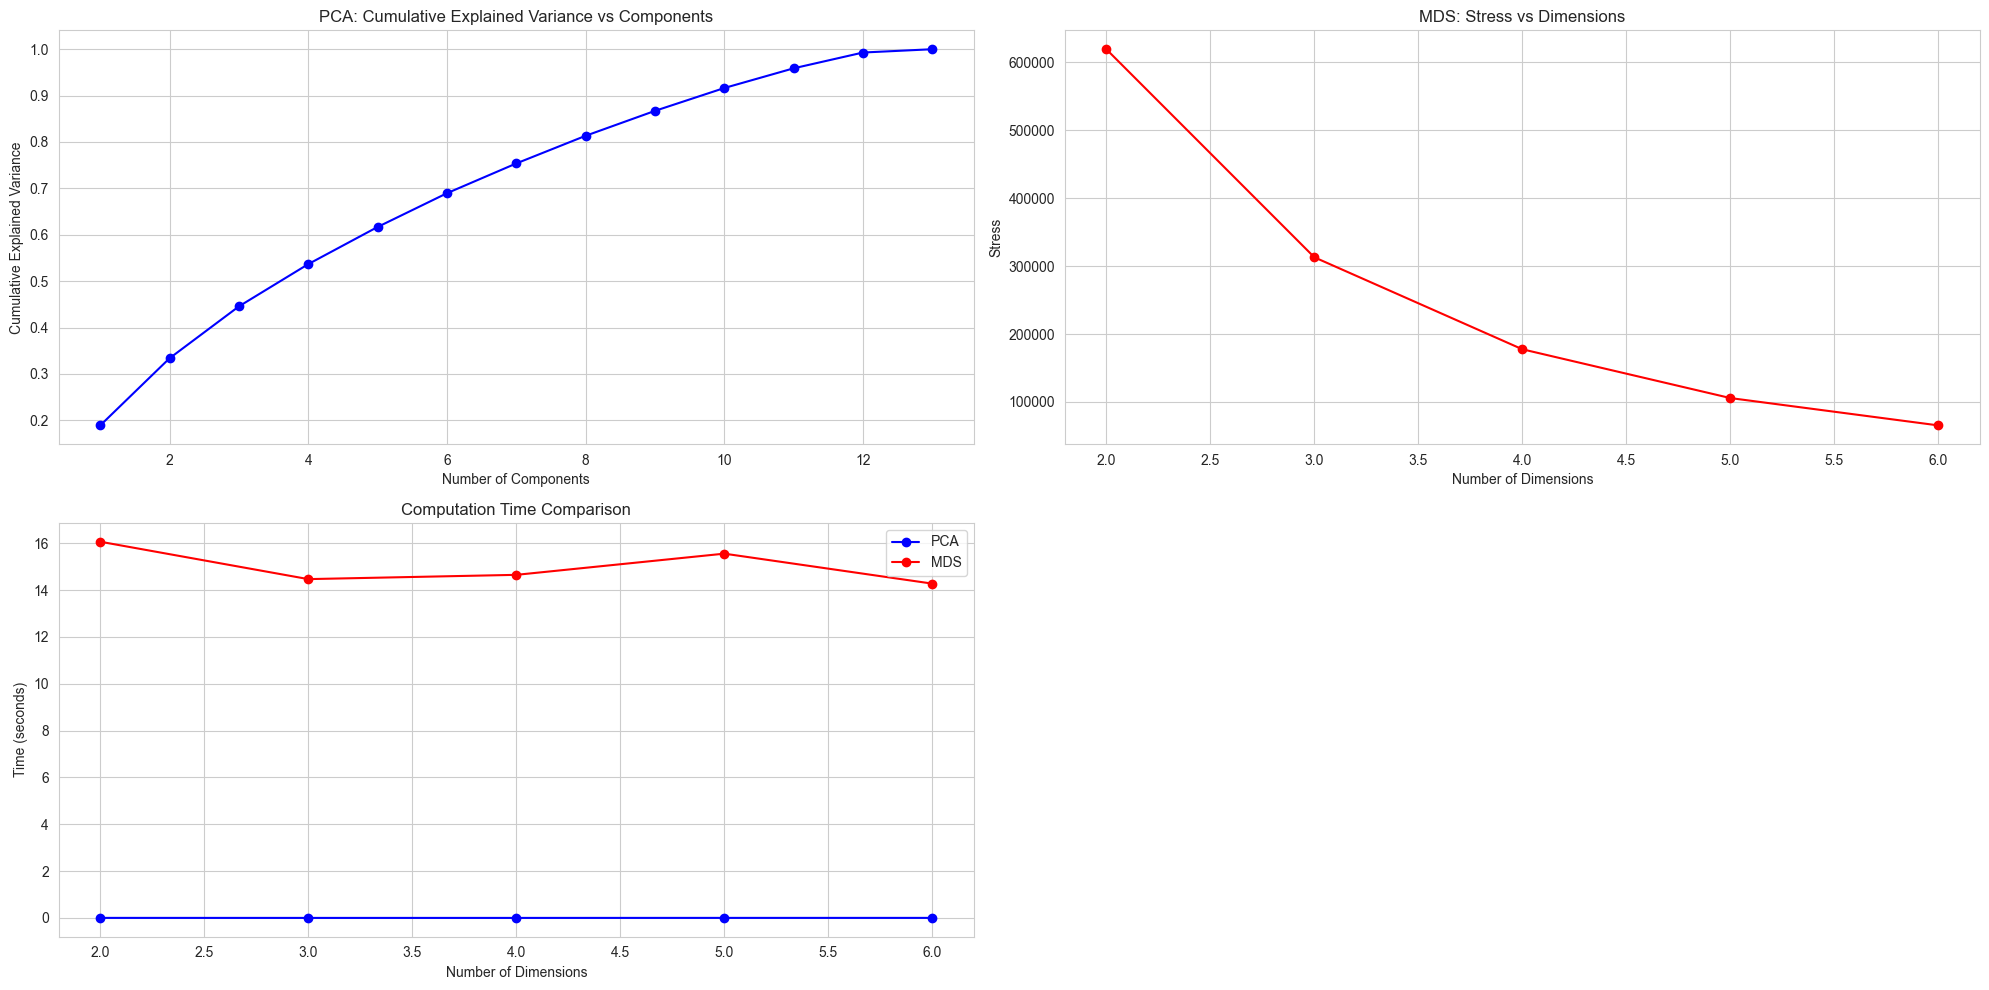


PCA Results:
Cumulative explained variance by dimensions:
1 dimensions: 0.189
2 dimensions: 0.334
3 dimensions: 0.446
4 dimensions: 0.537
5 dimensions: 0.617
6 dimensions: 0.690

MDS Results:
Stress values by dimensions:
2 dimensions: 619426.06
3 dimensions: 313018.39
4 dimensions: 177535.39
5 dimensions: 105679.72
6 dimensions: 65410.21

Computation Times (seconds):
Dimensions  PCA    MDS
         2  0.001 16.065
         3  0.000 14.468
         4  0.000 14.651
         5  0.001 15.555
         6  0.001 14.275


In [871]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import time

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features_for_clustering)

# Set dimensions to try
n_dimensions = [2, 3, 4, 5, 6]

# PCA Analysis
pca = PCA()
data_pca = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# MDS Analysis for different dimensions
mds_stress = []
mds_time = []
pca_time = []

for n_dim in n_dimensions:
    # PCA timing
    start_time = time.time()
    pca_n = PCA(n_components=n_dim)
    pca_n.fit_transform(data_scaled)
    pca_time.append(time.time() - start_time)
    
    # MDS timing and stress
    start_time = time.time()
    mds = MDS(n_components=n_dim, random_state=42)
    mds.fit_transform(data_scaled)
    mds_time.append(time.time() - start_time)
    mds_stress.append(mds.stress_)

# Plotting
plt.figure(figsize=(20, 10))

# Plot 1: PCA explained variance
plt.subplot(2, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance vs Components')
plt.grid(True)

# Plot 2: MDS Stress by dimensions
plt.subplot(2, 2, 2)
plt.plot(n_dimensions, mds_stress, 'ro-')
plt.xlabel('Number of Dimensions')
plt.ylabel('Stress')
plt.title('MDS: Stress vs Dimensions')
plt.grid(True)

# Plot 3: Computation Time Comparison
plt.subplot(2, 2, 3)
plt.plot(n_dimensions, pca_time, 'bo-', label='PCA')
plt.plot(n_dimensions, mds_time, 'ro-', label='MDS')
plt.xlabel('Number of Dimensions')
plt.ylabel('Time (seconds)')
plt.title('Computation Time Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print detailed results
print("\nPCA Results:")
print("Cumulative explained variance by dimensions:")
for i, var in enumerate(cumulative_variance[:6], 1):
    print(f"{i} dimensions: {var:.3f}")

print("\nMDS Results:")
print("Stress values by dimensions:")
for dim, stress in zip(n_dimensions, mds_stress):
    print(f"{dim} dimensions: {stress:.2f}")

print("\nComputation Times (seconds):")
print("Dimensions  PCA    MDS")
for dim, p_time, m_time in zip(n_dimensions, pca_time, mds_time):
    print(f"{dim:10d} {p_time:6.3f} {m_time:6.3f}")

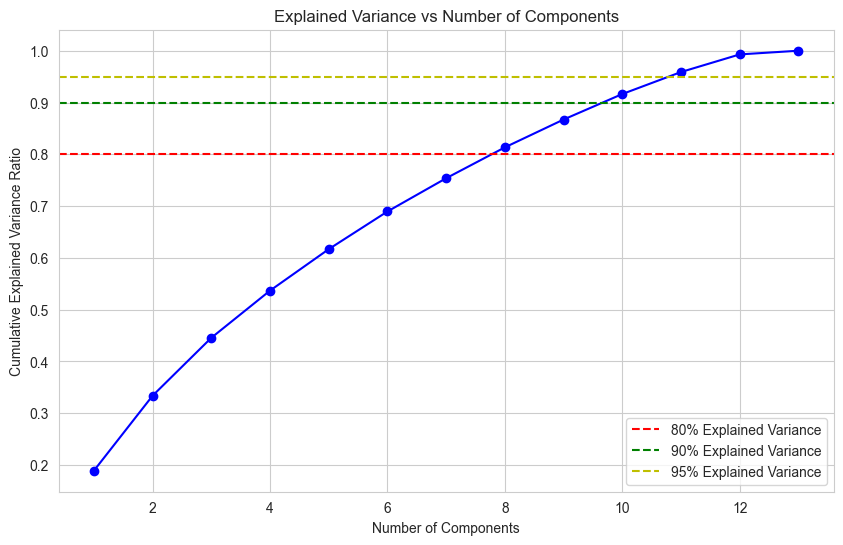


Number of components needed for:
80% variance: 8
90% variance: 10
95% variance: 11


In [872]:
# 4. Prepare data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)

# 5. Determine optimal number of PCA components
n_components = min(X_scaled.shape[0], X_scaled.shape[1])
pca_test = PCA(n_components=n_components)
pca_test.fit(X_scaled)

# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
cumsum = np.cumsum(pca_test.explained_variance_ratio_)
plt.plot(range(1, n_components + 1), cumsum, 'bo-')

# Add multiple threshold lines
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Explained Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Explained Variance')
plt.axhline(y=0.95, color='y', linestyle='--', label='95% Explained Variance')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components')
plt.legend()
plt.grid(True)
plt.show()

# Print the number of components needed for each threshold
n_components_80 = np.argmax(cumsum >= 0.80) + 1
n_components_90 = np.argmax(cumsum >= 0.90) + 1
n_components_95 = np.argmax(cumsum >= 0.95) + 1

print(f"\nNumber of components needed for:")
print(f"80% variance: {n_components_80}")
print(f"90% variance: {n_components_90}")
print(f"95% variance: {n_components_95}")

# 6. Apply PCA with chosen number of components (let's use 80% threshold as example)
pca = PCA(n_components=8, random_state=42)
X_pca = pca.fit_transform(X_scaled)

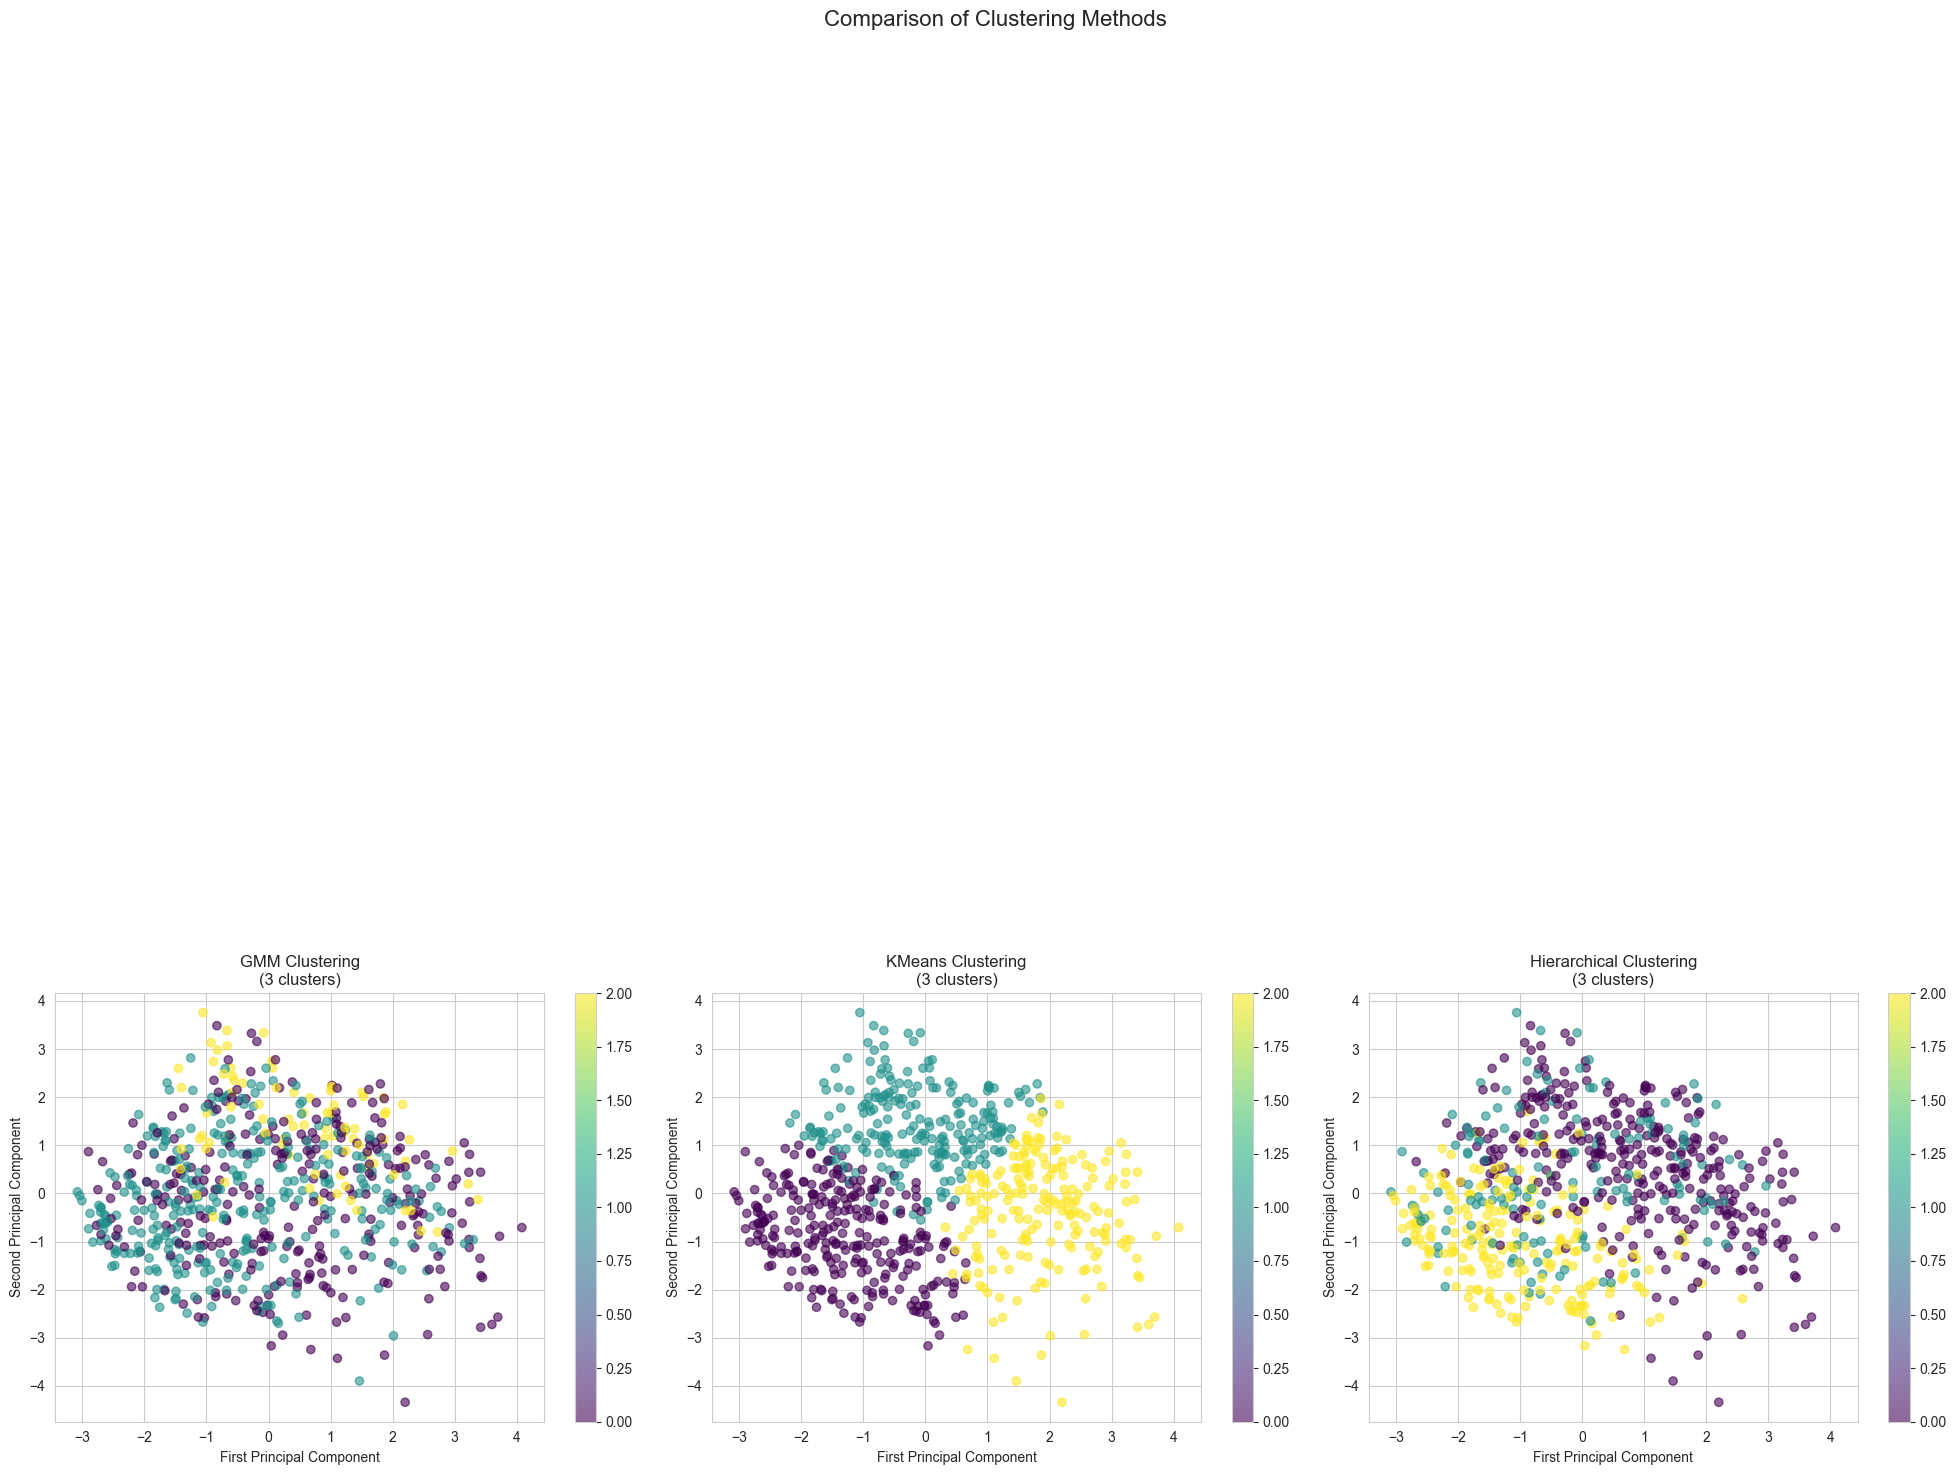


Comparison metrics for 4 clusters:

GMM:
Silhouette score: 0.070
Calinski-Harabasz score: 57.963
Davies-Bouldin score: 2.637
Cluster sizes: [292 326  86]

KMeans:
Silhouette score: 0.146
Calinski-Harabasz score: 124.514
Davies-Bouldin score: 1.983
Cluster sizes: [275 228 201]

Hierarchical:
Silhouette score: 0.125
Calinski-Harabasz score: 85.309
Davies-Bouldin score: 2.255
Cluster sizes: [339 144 221]


In [873]:
# Keep all the code the same until the optimal clusters part

# Plotting
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3)
fig.suptitle('Comparison of Clustering Methods', fontsize=16)

# Instead of finding optimal clusters, set fixed number of clusters
n_fixed_clusters = 3
final_clusters = {}

# GMM
gmm = GaussianMixture(n_components=n_fixed_clusters, random_state=42, n_init=10)
final_clusters['GMM'] = gmm.fit_predict(X_pca)

# K-means
kmeans = KMeans(n_clusters=n_fixed_clusters, random_state=42, n_init=10)
final_clusters['KMeans'] = kmeans.fit_predict(X_pca)

# Hierarchical
hierarchical = AgglomerativeClustering(n_clusters=n_fixed_clusters)
final_clusters['Hierarchical'] = hierarchical.fit_predict(X_pca)

# Plot clustering results
for i, (method, labels) in enumerate(final_clusters.items()):
    ax = fig.add_subplot(gs[2, i])
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
    ax.set_title(f'{method} Clustering\n({n_fixed_clusters} clusters)')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.grid(True)
    fig.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()  # Only one plt.show() at the end

# Print comparison metrics
print("\nComparison metrics for 4 clusters:")
for method, labels in final_clusters.items():
    print(f"\n{method}:")
    try:
        silhouette_avg = silhouette_score(X_pca, labels)
        calinski = calinski_harabasz_score(X_pca, labels)
        davies = davies_bouldin_score(X_pca, labels)
        
        print(f"Silhouette score: {silhouette_avg:.3f}")
        print(f"Calinski-Harabasz score: {calinski:.3f}")
        print(f"Davies-Bouldin score: {davies:.3f}")
        print(f"Cluster sizes: {np.bincount(labels)}")
    
    except ValueError as e:
        print(f"Error calculating scores: {e}")